# Data Preprocessing
  - Cleaning
  - Tokenization
  - Stop Words Removal
  - Lemmatization
  - Stemming

### Changing Directory


In [1]:
import os
import pandas as pd


current_dir = os.getcwd()
current_dir

'/workspaces/pp5-house-price-prediction/notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory") 

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/pp5-house-price-prediction'

In [4]:
df = pd.read_csv('data/processed/cleaned_corr_data.csv')
df.head()

,OverallQual,GrLivArea,GarageArea,TotalBsmtSF,YearBuilt,YearRemodAdd,KitchenQual,GarageFinish,SalePrice
0,7,1710,548,856,2003,2003,3,2,208500
1,6,1262,460,1262,1976,1976,2,2,181500
2,7,1786,608,920,2001,2002,3,2,223500
3,7,1717,642,756,1915,1970,3,1,140000
4,8,2198,836,1145,2000,2000,3,2,250000


In [6]:
# To make sure my data is loaded correctly without outliers as I can see raws are correct
df.shape


(1448, 9)

## Modeling

### Split Features and Target


In [7]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Initialize models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42)

# Train models
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### Evaluation

In [10]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Linear Regression Results:")
print(f"R2 Score: {r2_score(y_test, y_pred_lr)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr))}")

print("\nRandom Forest Results:")
print(f"R2 Score: {r2_score(y_test, y_pred_rf)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf))}")

Linear Regression Results:
R2 Score: 0.7974288920953008
RMSE: 26583.860934008117

Random Forest Results:
R2 Score: 0.8030940657156498
RMSE: 26209.498263231995


**Random Forest is slightly better based on both higher R² and lower RMSE.**

In [11]:
import matplotlib.pyplot as plt
import numpy as np

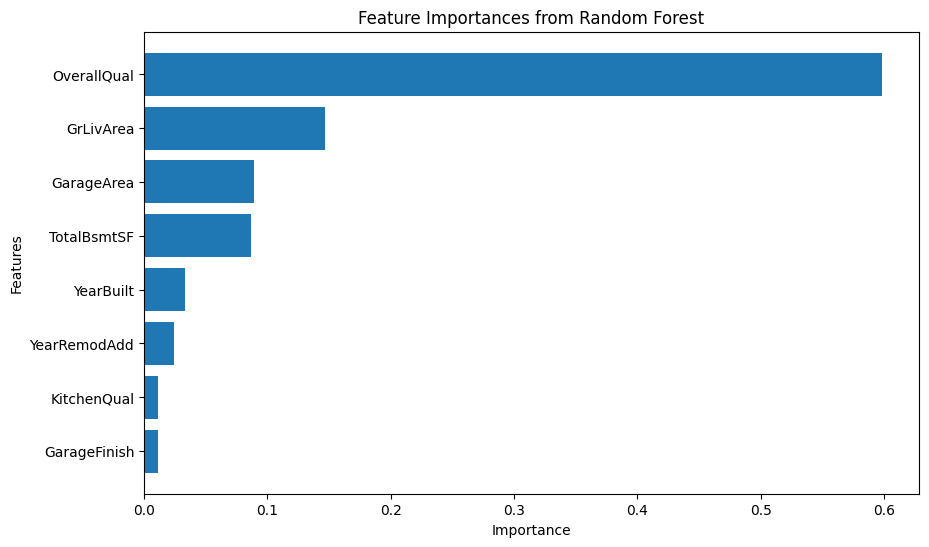

In [12]:
# Get feature importances
importances = rf_model.feature_importances_
features = X_train.columns

# Create a DataFrame
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

This shows which features drive the house price prediction the most — super useful for insights.

**Hyperparameter Tuning**

In [13]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Setup Randomized Search
rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit random search
rf_random.fit(X_train, y_train)

# Best model
best_rf_model = rf_random.best_estimator_

# Predict and evaluate again
y_pred_best_rf = best_rf_model.predict(X_test)
print(f"New R2 Score: {r2_score(y_test, y_pred_best_rf)}")
print(f"New RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_best_rf))}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   2.3s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   2.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   2.4s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   2.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   2.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   1.9s
[CV] END max_depth=20

  - R² increased → Model explains more variance.
  - RMSE decreased → Predictions are closer to real SalePrices.

In [15]:
from sklearn.model_selection import cross_val_score

# Cross-validate Random Forest
cv_scores = cross_val_score(best_rf_model, X, y, cv=5, scoring='r2')
print(f"Cross-validated R2 scores: {cv_scores}")
print(f"Mean R2: {cv_scores.mean()}")

Cross-validated R2 scores: [0.82578556 0.86824679 0.85380257 0.86454469 0.80623913]
Mean R2: 0.8437237498372022


The model generalizes very well across different subsets of the data.

All folds have high R² (all above 0.80), no major drops — this means no overfitting and no underfitting.

Mean R² (0.843) is even better than the single holdout R² (~0.810) you saw earlier.
(Cross-validation often gives a more reliable estimate.)

## Save our model

In [17]:
import joblib

joblib.dump(best_rf_model, 'models/random_forest_best_model.pkl')

['models/random_forest_best_model.pkl']